In [ ]:
!pip install pmdarima -q
!pip install sktime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 13.8 MB/s eta 0:00:00


In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import r2_score
import plotly.graph_objects as go

# Seasonal Analysis with Fourier Terms

In [ ]:
# train_df = pd.read_csv('/content/drive/MyDrive/mmm_data/train_data.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/mmm_data/test_data.csv')

df = pd.read_csv('/content/drive/MyDrive/mmm_data/MMM_data.csv')
df = df[['DATE', 'SALES ($)']].rename(columns={"DATE": "date", "SALES ($)": "revenue"})
df['date'] = pd.to_datetime(df['date'])
df['day_of_year'] = df['date'].dt.dayofyear
df

,date,revenue,day_of_year
0,2010-01-01,1533268.80,1
1,2010-01-02,1542670.92,2
2,2010-01-03,1520973.72,3
3,2010-01-04,1510125.12,4
4,2010-01-05,1892719.08,5
...,...,...,...
2608,2017-02-21,2521937.88,52
2609,2017-02-22,2214199.26,53
2610,2017-02-23,2165742.18,54
2611,2017-02-24,2125240.74,55


### Check for most suitable number of Fourier terms

In [ ]:
fourier_terms_list = []
aic_list, bic_list, smape_list, mae_list, r2_list = [], [], [], [], []

counter = 1
for fourier_terms in range(1, 11):
    group = df.copy()

    # Stabilise the variance
    group['target_Boxcox'], lam = boxcox(group['revenue'])
    group.dropna(inplace=True)

    # Get fourier features
    for order in range(1, fourier_terms+1):
        group[f'fourier_sin_order_{order}'] = np.sin(2 * np.pi * order * group['day_of_year'] / 365)
        group[f'fourier_cos_order_{order}'] = np.cos(2 * np.pi * order * group['day_of_year'] / 365)

    # name of fourier features
    fourier_features = [i for i in list(group) if i.startswith('fourier')]

    # Split train and test
    train = group[group['date'] <= pd.to_datetime('2014-12-31')]
    test = group[group['date'] > pd.to_datetime('2014-12-31')]

    # Build auto-ARIMA model with fourier features
    model = pm.auto_arima(train['target_Boxcox'],
                        X=train[fourier_features],
                        seasonal=False,
                        stepwise=True,
                        suppress_warnings=True,
                        max_order=None,
                        information_criterion='aic',
                        error_action="ignore")

    # Get the forecasts and apply inverse box-cox transform
    boxcox_forecasts = model.predict(n_periods=len(test), X=test[fourier_features])
    forecasts = inv_boxcox(boxcox_forecasts, lam)
    smape = mean_absolute_percentage_error(test['revenue'].tolist(), forecasts, symmetric=True)
    mae = mean_absolute_error(test['revenue'].tolist(), forecasts, symmetric=True)
    r2 = r2_score(test['revenue'].tolist(), forecasts)

    print(f"Fourier Terms: {fourier_terms}, SMAPE: {smape}, MAE: {mae}, R2: {r2}")
    # print(model.summary())
    # print(model.aic())
    # print(model.bic())

    # hotel_list.append(name)
    # granular_type_list.append('base')
    # granular_value_list.append('base')
    fourier_terms_list.append(fourier_terms)
    aic_list.append(model.aic())
    bic_list.append(model.aic())
    smape_list.append(smape)
    mae_list.append(mae)
    r2_list.append(r2)

    fig = go.Figure()
    title = f"Revenue forecast with {fourier_terms} Fourier Terms"
    fig.add_trace(go.Scatter(x=train['date'], y=train['revenue'], name='Train'))
    fig.add_trace(go.Scatter(x=test['date'], y=test['revenue'], name='Test'))
    fig.add_trace(go.Scatter(x=test['date'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                    width=1000, title_x=0.5, height=400, xaxis_title='Date',
                    yaxis_title="revenue")

    fig.show()
    print(forecasts)

    counter += 1

base_result = {
    # 'hotel': hotel_list,
    # 'granular_type': granular_type_list,
    # 'granular_value':granular_value_list,
    'fourier_tems': fourier_terms_list,
    'aic': aic_list,
    'bic': bic_list,
    'smape': smape_list,
    'mae': mae_list,
    'r2': r2_list}

base_result_df = pd.DataFrame(base_result)

Fourier Terms: 1, SMAPE: 1.0912365582230594, MAE: 3647362.466469413, R2: -24.42890103600255


1826    1.578178e+06
1827    1.538339e+06
1828    1.595431e+06
1829    1.568895e+06
1830    1.589555e+06
            ...     
2608    1.284714e+07
2609    1.286151e+07
2610    1.289168e+07
2611    1.290590e+07
2612    1.293037e+07
Length: 787, dtype: float64
Fourier Terms: 2, SMAPE: 0.633813918914345, MAE: 866359.8101288514, R2: -0.6449975635791831


1826    1.480106e+06
1827    1.383355e+06
1828    1.389061e+06
1829    1.339301e+06
1830    1.329468e+06
            ...     
2608    1.036476e+06
2609    1.023212e+06
2610    1.031114e+06
2611    1.020936e+06
2612    1.020503e+06
Length: 787, dtype: float64
Fourier Terms: 3, SMAPE: 0.48143373439015474, MAE: 633132.217951404, R2: 0.2905890425642341


1826    1.569406e+06
1827    1.532101e+06
1828    1.585927e+06
1829    1.559271e+06
1830    1.581305e+06
            ...     
2608    2.657125e+06
2609    2.651344e+06
2610    2.654207e+06
2611    2.648159e+06
2612    2.646679e+06
Length: 787, dtype: float64
Fourier Terms: 4, SMAPE: 0.778288936760627, MAE: 1004726.0930576118, R2: -1.2512727883624755


1826    1.471456e+06
1827    1.351316e+06
1828    1.343793e+06
1829    1.241907e+06
1830    1.231277e+06
            ...     
2608    6.559810e+05
2609    6.508550e+05
2610    6.461358e+05
2611    6.403721e+05
2612    6.350281e+05
Length: 787, dtype: float64
Fourier Terms: 5, SMAPE: 0.632118459972316, MAE: 870344.5085154109, R2: -0.732593905639773


1826    1.500538e+06
1827    1.394121e+06
1828    1.366351e+06
1829    1.273715e+06
1830    1.215572e+06
            ...     
2608    9.339391e+05
2609    9.250241e+05
2610    9.193409e+05
2611    9.098936e+05
2612    9.026927e+05
Length: 787, dtype: float64
Fourier Terms: 6, SMAPE: 0.633599005363463, MAE: 872292.9914094447, R2: -0.7463271191823648


1826    1.506140e+06
1827    1.398460e+06
1828    1.374473e+06
1829    1.274043e+06
1830    1.215278e+06
            ...     
2608    9.720956e+05
2609    9.614473e+05
2610    9.529771e+05
2611    9.410660e+05
2612    9.303194e+05
Length: 787, dtype: float64
Fourier Terms: 7, SMAPE: 0.6261953563023518, MAE: 855806.5394516543, R2: -0.6001092491778086


1826    1.456928e+06
1827    1.329973e+06
1828    1.292489e+06
1829    1.201917e+06
1830    1.162340e+06
            ...     
2608    1.229093e+06
2609    1.202568e+06
2610    1.187039e+06
2611    1.157071e+06
2612    1.134922e+06
Length: 787, dtype: float64
Fourier Terms: 8, SMAPE: 0.6338989226939924, MAE: 867122.2117284673, R2: -0.7066647088149725


1826    1.459080e+06
1827    1.327965e+06
1828    1.278800e+06
1829    1.164766e+06
1830    1.101798e+06
            ...     
2608    1.138932e+06
2609    1.094457e+06
2610    1.057732e+06
2611    1.012806e+06
2612    9.717023e+05
Length: 787, dtype: float64
Fourier Terms: 9, SMAPE: 0.7916003315293606, MAE: 1008611.887493108, R2: -1.3102441741559812


1826    1.457235e+06
1827    1.308385e+06
1828    1.252198e+06
1829    1.147545e+06
1830    1.076207e+06
            ...     
2608    6.864217e+05
2609    6.503209e+05
2610    6.153448e+05
2611    5.809649e+05
2612    5.490170e+05
Length: 787, dtype: float64
Fourier Terms: 10, SMAPE: 0.764312191186549, MAE: 986239.1512336546, R2: -1.208299292991509


1826    1.437872e+06
1827    1.281876e+06
1828    1.228116e+06
1829    1.111534e+06
1830    1.050266e+06
            ...     
2608    7.214983e+05
2609    6.839205e+05
2610    6.492036e+05
2611    6.149943e+05
2612    5.840373e+05
Length: 787, dtype: float64
Fourier Terms: 11, SMAPE: 0.7855432825156252, MAE: 1003582.1299579296, R2: -1.285651081452269


1826    1.455184e+06
1827    1.304612e+06
1828    1.246751e+06
1829    1.128923e+06
1830    1.061718e+06
            ...     
2608    6.686929e+05
2609    6.313880e+05
2610    5.982802e+05
2611    5.648476e+05
2612    5.354866e+05
Length: 787, dtype: float64


In [ ]:
base_result_df

,fourier_tems,aic,bic,smape,mae,r2
0,1,9114.526963,9114.526963,1.091237,3.647362e+06,-24.428901
1,2,9048.408558,9048.408558,0.633814,8.663598e+05,-0.644998
2,3,9118.006926,9118.006926,0.481434,6.331322e+05,0.290589
3,4,9063.301672,9063.301672,0.778289,1.004726e+06,-1.251273
4,5,9041.474469,9041.474469,0.632118,8.703445e+05,-0.732594
5,6,9044.324207,9044.324207,0.633599,8.722930e+05,-0.746327
6,7,9041.244671,9041.244671,0.626195,8.558065e+05,-0.600109
7,8,9003.938472,9003.938472,0.633899,8.671222e+05,-0.706665
8,9,9004.152207,9004.152207,0.791600,1.008612e+06,-1.310244
9,10,8988.275992,8988.275992,0.764312,9.862392e+05,-1.208299


According the statistics and visualizations, the most optimal order of the Fourier terms is 3

In [ ]:
# Get fourier features
opt_fourier_order = 3

for order in range(1, opt_fourier_order+1):
  df[f'fourier_sin_order_{order}'] = np.sin(2 * np.pi * order * df['day_of_year'] / 365)
  df[f'fourier_cos_order_{order}'] = np.cos(2 * np.pi * order * df['day_of_year'] / 365)

In [ ]:
display(df)

,date,revenue,day_of_year,fourier_sin_order_1,fourier_cos_order_1,fourier_sin_order_2,fourier_cos_order_2,fourier_sin_order_3,fourier_cos_order_3
0,2010-01-01,1533268.80,1,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667
1,2010-01-02,1542670.92,2,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671
2,2010-01-03,1520973.72,3,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023
3,2010-01-04,1510125.12,4,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740
4,2010-01-05,1892719.08,5,0.085965,0.996298,0.171293,0.985220,0.255353,0.966848
...,...,...,...,...,...,...,...,...,...
2608,2017-02-21,2521937.88,52,0.780296,0.625411,0.976011,-0.217723,0.440519,-0.897743
2609,2017-02-22,2214199.26,53,0.790946,0.611886,0.967938,-0.251190,0.393590,-0.919286
2610,2017-02-23,2165742.18,54,0.801361,0.598181,0.958718,-0.284359,0.345612,-0.938377
2611,2017-02-24,2125240.74,55,0.811539,0.584298,0.948362,-0.317191,0.296713,-0.954967


# Seasonal Analysis with Prophet

In [ ]:
from prophet import Prophet

In [ ]:
train = df[df['date'] <= pd.to_datetime('2014-12-31')]
train = train[['date', 'revenue']].rename(columns={"date": "ds", "revenue": "y"})
test = df[df['date'] > pd.to_datetime('2014-12-31')]
test = test[['date', 'revenue']].rename(columns={"date": "ds", "revenue": "y"})

In [ ]:
prophet = Prophet()
# prophet.add_regressor(name = "events_event2")
# prophet.add_regressor(name = "events_na")
prophet.fit(train[["ds", "y"]])
x_pred = prophet.predict(train[["ds", "y"]])
y_pred = prophet.predict(test[["ds", "y"]])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp904nwe56/qqyzgk7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp904nwe56/k2y2ie2a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11098', 'data', 'file=/tmp/tmp904nwe56/qqyzgk7x.json', 'init=/tmp/tmp904nwe56/k2y2ie2a.json', 'output', 'file=/tmp/tmp904nwe56/prophet_modelypsmaivx/prophet_model-20240701054859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:48:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:48:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


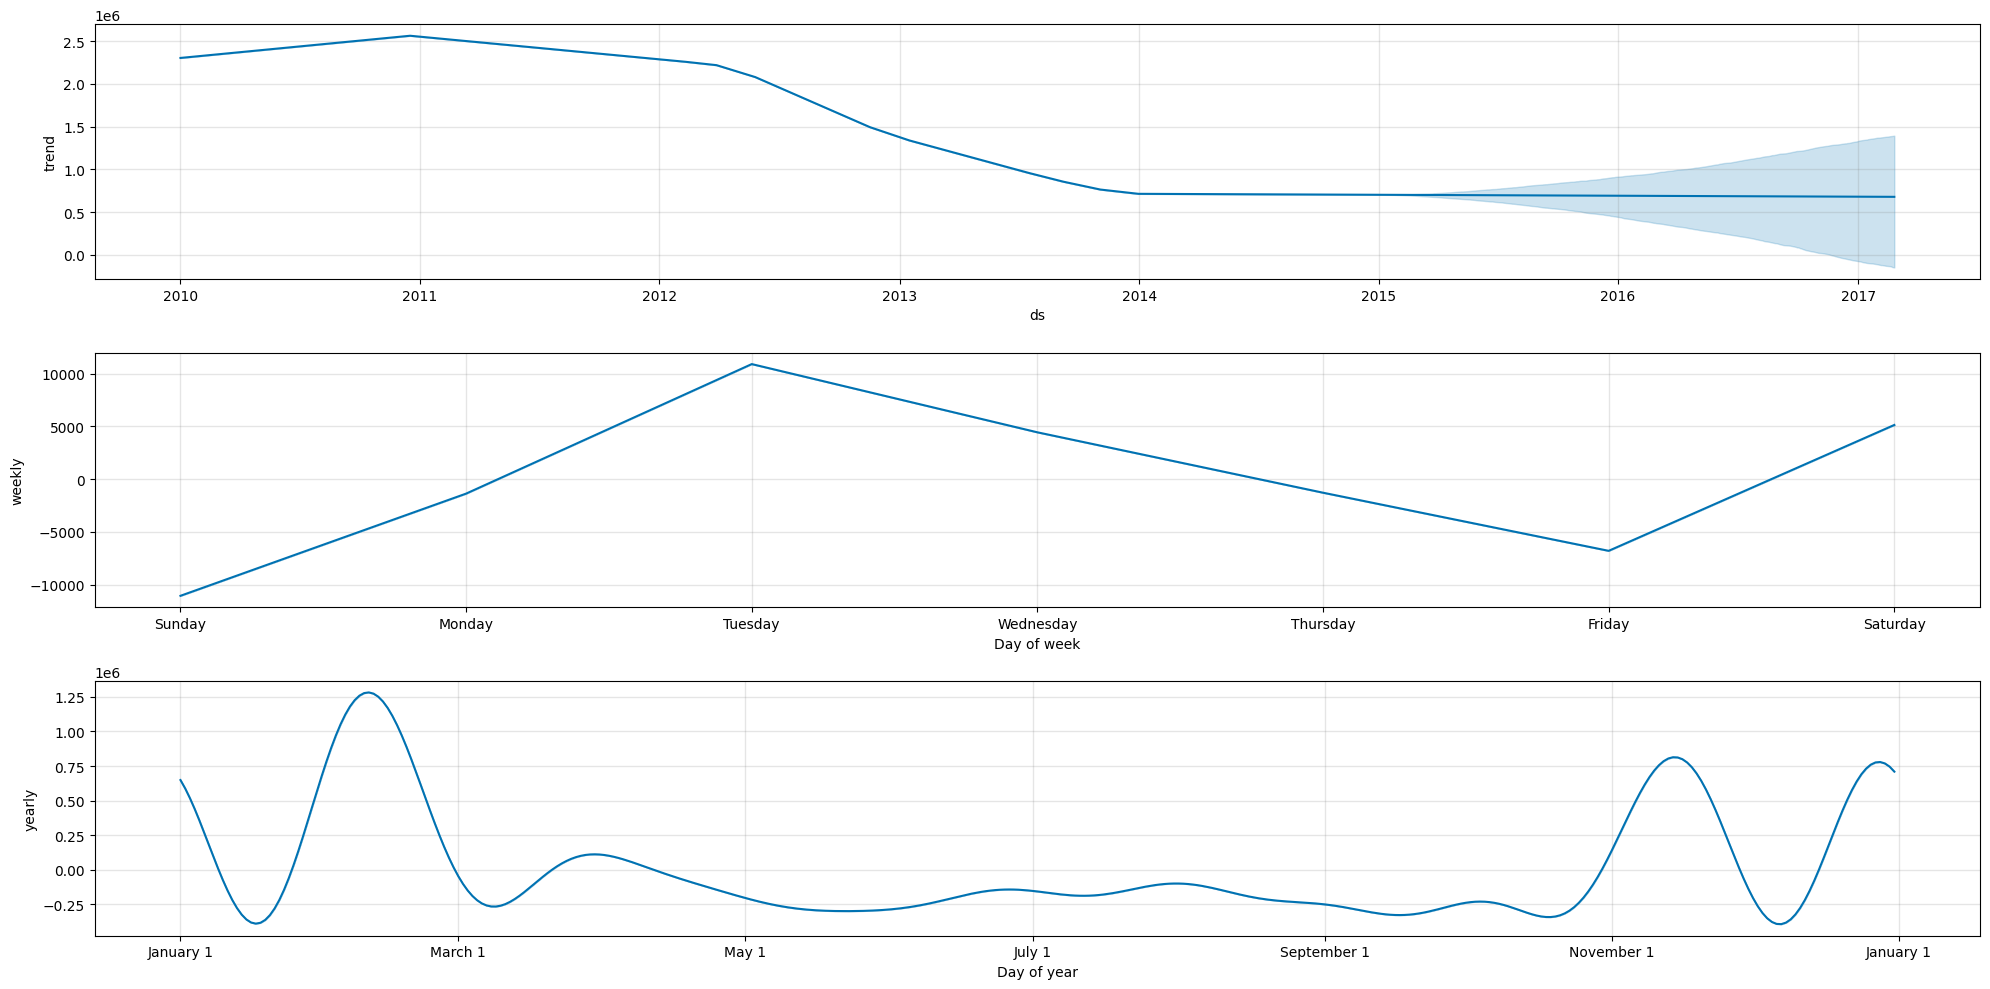

In [ ]:
prophet_seasonal = pd.concat([x_pred, y_pred], ignore_index=True, axis=0)
plot = prophet.plot_components(prophet_seasonal, figsize = (20, 10))

In [ ]:
prophet_seasonal[['ds', 'trend', 'weekly', 'yearly']]

,ds,trend,weekly,yearly
0,2010-01-01,2.303417e+06,-6793.177426,662551.380265
1,2010-01-02,2.304158e+06,5141.894033,604349.057920
2,2010-01-03,2.304900e+06,-11057.012409,536748.543386
3,2010-01-04,2.305642e+06,-1368.201626,461266.466193
4,2010-01-05,2.306383e+06,10913.773000,379605.238805
...,...,...,...,...
2608,2017-02-21,6.784664e+05,10913.773000,616265.329630
2609,2017-02-22,6.784358e+05,4444.571244,522038.874745
2610,2017-02-23,6.784053e+05,-1281.846815,428586.520394
2611,2017-02-24,6.783748e+05,-6793.177426,337313.097466


In [ ]:
df = df.merge(prophet_seasonal[['ds', 'trend', 'weekly', 'yearly']], left_on='date', right_on='ds', how='left')
df.drop(columns=['ds'], inplace=True)
df

,date,revenue,day_of_year,fourier_sin_order_1,fourier_cos_order_1,fourier_sin_order_2,fourier_cos_order_2,fourier_sin_order_3,fourier_cos_order_3,trend,weekly,yearly
0,2010-01-01,1533268.80,1,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,2.303417e+06,-6793.177426,662551.380265
1,2010-01-02,1542670.92,2,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,2.304158e+06,5141.894033,604349.057920
2,2010-01-03,1520973.72,3,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,2.304900e+06,-11057.012409,536748.543386
3,2010-01-04,1510125.12,4,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,2.305642e+06,-1368.201626,461266.466193
4,2010-01-05,1892719.08,5,0.085965,0.996298,0.171293,0.985220,0.255353,0.966848,2.306383e+06,10913.773000,379605.238805
...,...,...,...,...,...,...,...,...,...,...,...,...
2608,2017-02-21,2521937.88,52,0.780296,0.625411,0.976011,-0.217723,0.440519,-0.897743,6.784664e+05,10913.773000,616265.329630
2609,2017-02-22,2214199.26,53,0.790946,0.611886,0.967938,-0.251190,0.393590,-0.919286,6.784358e+05,4444.571244,522038.874745
2610,2017-02-23,2165742.18,54,0.801361,0.598181,0.958718,-0.284359,0.345612,-0.938377,6.784053e+05,-1281.846815,428586.520394
2611,2017-02-24,2125240.74,55,0.811539,0.584298,0.948362,-0.317191,0.296713,-0.954967,6.783748e+05,-6793.177426,337313.097466


In [ ]:
df.describe()

,date,revenue,day_of_year,fourier_sin_order_1,fourier_cos_order_1,fourier_sin_order_2,fourier_cos_order_2,fourier_sin_order_3,fourier_cos_order_3,trend,weekly,yearly
count,2613,2.613000e+03,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2.613000e+03,2613.000000,2.613000e+03
mean,2013-07-30 00:00:00,1.641507e+06,179.828932,0.009724,0.018945,0.015207,0.010920,0.014675,0.002218,1.393729e+06,-0.631949,9.731563e+03
min,2010-01-01 00:00:00,4.627096e+05,1.000000,-0.999991,-0.999963,-0.999991,-0.999963,-0.999991,-0.999963,6.783442e+05,-11057.012409,-3.929568e+05
25%,2011-10-16 00:00:00,6.717679e+05,86.000000,-0.693281,-0.696376,-0.693281,-0.696376,-0.693281,-0.708627,6.982888e+05,-6793.177426,-2.569785e+05
50%,2013-07-30 00:00:00,1.605095e+06,179.000000,0.034422,0.038722,0.034422,0.021516,0.034422,0.004304,9.320659e+05,-1281.846815,-1.578964e+05
75%,2015-05-14 00:00:00,2.267206e+06,272.000000,0.705584,0.738326,0.723644,0.714673,0.717677,0.714673,2.323600e+06,5141.894033,1.020080e+05
max,2017-02-25 00:00:00,5.960221e+06,366.000000,0.999991,1.000000,0.999991,1.000000,0.999991,1.000000,2.563006e+06,10913.773000,1.282219e+06
std,NaN,9.416673e+05,106.736491,0.703303,0.710841,0.708214,0.706021,0.707456,0.706873,7.701632e+05,6941.480260,4.026337e+05


In [ ]:
# Save file
df.to_csv('/content/drive/MyDrive/mmm_data/seasonal_components.csv', index=False)